## Bipartite network

For each location $l \in L$ in the dataset, we maintained a dictionary structure containing:

- A set of characters $C_l = \{c_1, c_2, \ldots, c_n\}$ appearing in location $l$
- Appearance counts $w(c,l)$ representing the number of scenes in which character $c$ appears at location $l$
- A sentiment score $s(l)$ representing the emotional valence of location $l$

We formalized the character-location relationships as a bipartite graph $G = (C \cup L, E)$, where:

- $C$ is the set of character nodes
- $L$ is the set of location nodes with sentiment attribute $s(l)$
- $E \subseteq C \times L$ is the set of edges connecting characters to locations

Each edge $(c,l) \in E$ is weighted by the appearance count $w(c,l)$, representing the frequency of character $c$ appearing at location $l$.


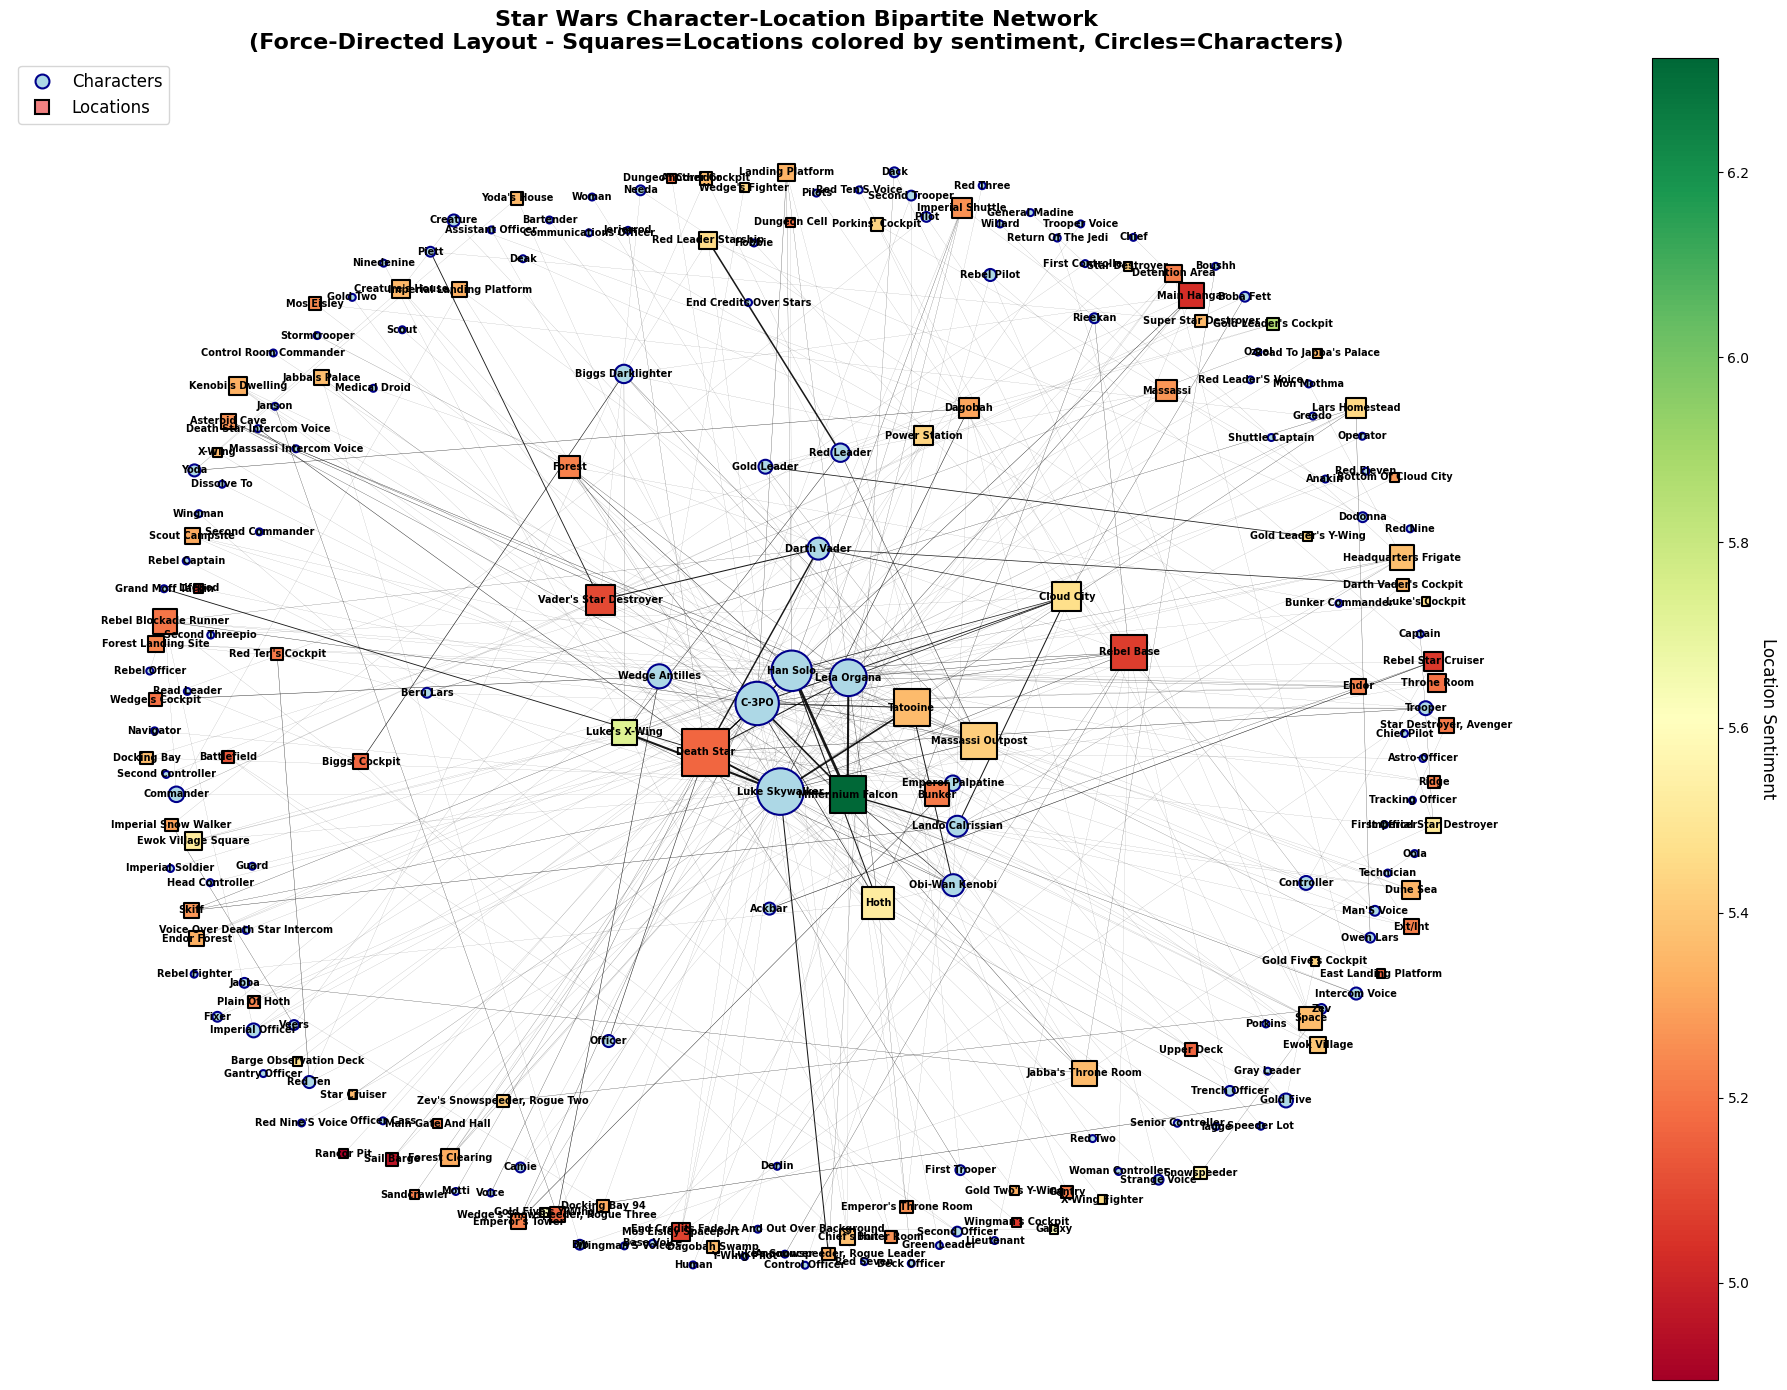

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import numpy as np

# read location_characters_dict from json location_characters_sentiment.json
import json
with open('../data/location_characters_with_sentiment.json', 'r') as f:
    location_characters_dict = json.load(f) 


# Create bipartite graph
G_bipartite = nx.Graph()

# Add nodes and edges
for location, data in location_characters_dict.items():
    G_bipartite.add_node(location, bipartite=0, sentiment=data['sentiment'], node_type='location')
    
    for char, count in data['characters'].items():
        if char not in G_bipartite:
            G_bipartite.add_node(char, bipartite=1, node_type='character')
        G_bipartite.add_edge(location, char, weight=count)

# Separate nodes by type
char_nodes = [node for node, d in G_bipartite.nodes(data=True) if d['node_type'] == 'character']
loc_nodes = [node for node, d in G_bipartite.nodes(data=True) if d['node_type'] == 'location']

# Calculate degrees for filtering
location_degrees = {loc: G_bipartite.degree(loc) for loc in loc_nodes}

# Get sentiments and calculate min/max
sentiments = [G_bipartite.nodes[node]['sentiment'] for node in loc_nodes if G_bipartite.nodes[node]['sentiment'] is not None]
min_sentiment = min(sentiments) if sentiments else 1.0
max_sentiment = max(sentiments) if sentiments else 10.0

# Get sentiments for location nodes (use mid value for None)
sentiments_for_colors = [G_bipartite.nodes[node]['sentiment'] if G_bipartite.nodes[node]['sentiment'] is not None else (min_sentiment + max_sentiment) / 2 for node in loc_nodes]

# Create figure
fig, ax = plt.subplots(figsize=(18, 14))

# Use spring layout for bipartite network
pos_bipartite = nx.spring_layout(
    G_bipartite, k=1.5, iterations=50, seed=42, weight="weight"
)

# Node sizes
char_node_sizes = [G_bipartite.degree(node) * 25 for node in char_nodes]
loc_node_sizes = [G_bipartite.degree(node) * 40 for node in loc_nodes]

# Draw character nodes (circles)
nx.draw_networkx_nodes(
    G_bipartite,
    pos_bipartite,
    nodelist=char_nodes,
    node_size=char_node_sizes,
    node_color="lightblue",
    edgecolors="darkblue",
    linewidths=1.5,
    ax=ax,
)

# Draw location nodes (squares) with sentiment-based colors
nx.draw_networkx_nodes(
    G_bipartite,
    pos_bipartite,
    nodelist=loc_nodes,
    node_size=loc_node_sizes,
    node_shape='s',
    node_color=sentiments_for_colors,
    cmap='RdYlGn',
    vmin=min_sentiment,
    vmax=max_sentiment,
    edgecolors="black",
    linewidths=1.5,
    ax=ax,
)

# Draw edges
edges_bi = G_bipartite.edges()
weights_bi = [G_bipartite[u][v]["weight"] for u, v in edges_bi]
max_weight_bi = max(weights_bi) if weights_bi else 1
edge_widths_bi = [w / max_weight_bi * 2 for w in weights_bi]

nx.draw_networkx_edges(
    G_bipartite,
    pos_bipartite,
    width=edge_widths_bi,
    alpha=0.9,
    edge_color="black",
    ax=ax,
)

# Draw all character labels
nx.draw_networkx_labels(
    G_bipartite,
    pos_bipartite,
    labels={node: node if node in char_nodes else "" for node in G_bipartite.nodes()},
    font_size=7,
    font_weight="bold",
    ax=ax,
)

# Draw ALL location labels with same font size
nx.draw_networkx_labels(
    G_bipartite,
    pos_bipartite,
    labels={node: node if node in loc_nodes else "" for node in G_bipartite.nodes()},
    font_size=7,
    font_color="black",
    font_weight="bold",
    ax=ax,
)

# Add colorbar for sentiment
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min_sentiment, vmax=max_sentiment))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Location Sentiment', rotation=270, labelpad=20, fontsize=12)

# Create custom legend to avoid overlap
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Characters',
           markerfacecolor='lightblue', markeredgecolor='darkblue', 
           markersize=10, markeredgewidth=1.5),
    Line2D([0], [0], marker='s', color='w', label='Locations',
           markerfacecolor='lightcoral', markeredgecolor='black', 
           markersize=10, markeredgewidth=1.5)
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

ax.set_title(
    "Star Wars Character-Location Bipartite Network\n(Force-Directed Layout - Squares=Locations colored by sentiment, Circles=Characters)",
    fontsize=16,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
# save figure
# plt.savefig('../figures/bipartite_network_with_sentiment.png', dpi=300)

plt.show()

Figure: Bipartite network of characters and locations in the Star Wars original trilogy.

### Network Visualization

Node visual encoding followed these conventions:

- **Shape**: Circles for characters, squares for locations
- **Size**: Proportional to weighted degree $\deg_w(v) = \sum_{u \in N(v)} w(v,u)$, where $N(v)$ denotes the neighbors of node $v$
- **Color**: Mapped to sentiment scores using the RdYlGn (Red-Yellow-Green) colormap, where red indicates negative sentiment, yellow neutral, and green positive

Edge thickness was scaled proportionally to normalized weights.

In [23]:
print(f"\nLocation sentiment statistics:")
print(f"Number of characters: {G_bipartite.number_of_nodes() - len(loc_nodes)}")
print(f"Number of locations: {len(loc_nodes)}")
print(f"Number of connections: {G_bipartite.number_of_edges()}")
print(f"Min sentiment: {min_sentiment:.3f}, Max sentiment: {max_sentiment:.3f}")


Location sentiment statistics:
Number of characters: 128
Number of locations: 94
Number of connections: 378
Min sentiment: 4.895, Max sentiment: 6.324


### Sentiment Projection from Locations to Characters

To transfer emotional context from locations to characters, we employed a weighted averaging scheme. For each character $c \in C$, we computed a projected sentiment score $S(c)$ based on all locations $L_c \subseteq L$ to which the character is connected:

$$S(c) = \frac{\sum_{l \in L_c} w(c, l) \cdot s(l)}{\sum_{l \in L_c} w(c, l)}$$

where:

- $L_c = \{l \in L : (c, l) \in E\}$ is the set of locations visited by character $c$
- $w(c,l)$ is the edge weight (appearance count)
- $s(l)$ is the sentiment score of location $l$

This formulation ensures that characters appearing more frequently in certain locations are more strongly influenced by those locations' sentiment scores. Characters with no valid location sentiments were assigned null values and excluded from sentiment-based analyses.

## Bipartite Graph Projection to Character Network

To analyze character relationships mediated by shared locations, we projected the bipartite graph onto the character space, creating a unipartite character network $G' = (C, E')$.

For each location $l \in L$ with connected characters $C_l = \{c_1, c_2, \ldots, c_n\}$, we created edges between all character pairs $(c_i, c_j)$ where $i \neq j$. The weight of each projected edge represents the strength of co-occurrence through shared locations.

The edge weight between characters $c_i$ and $c_j$ through location $l$ was computed as:

$$w_l(c_i, c_j) = \min(w(c_i, l), w(c_j, l))$$

This conservative estimate uses the minimum appearance count, ensuring that edge weights reflect genuine co-presence rather than independent visits to the same location.

When multiple locations connect the same character pair, we summed their contributions:

$$W(c_i, c_j) = \sum_{l \in L_{ij}} w_l(c_i, c_j)$$

where $L_{ij} = \{l \in L : (c_i, l) \in E \wedge (c_j, l) \in E\}$ is the set of locations shared by both characters.

The projection algorithm transforms spatial co-occurrence into direct character relationships, enabling network analysis techniques such as community detection and centrality measures on the character space while preserving the sentiment information inherited from locations.



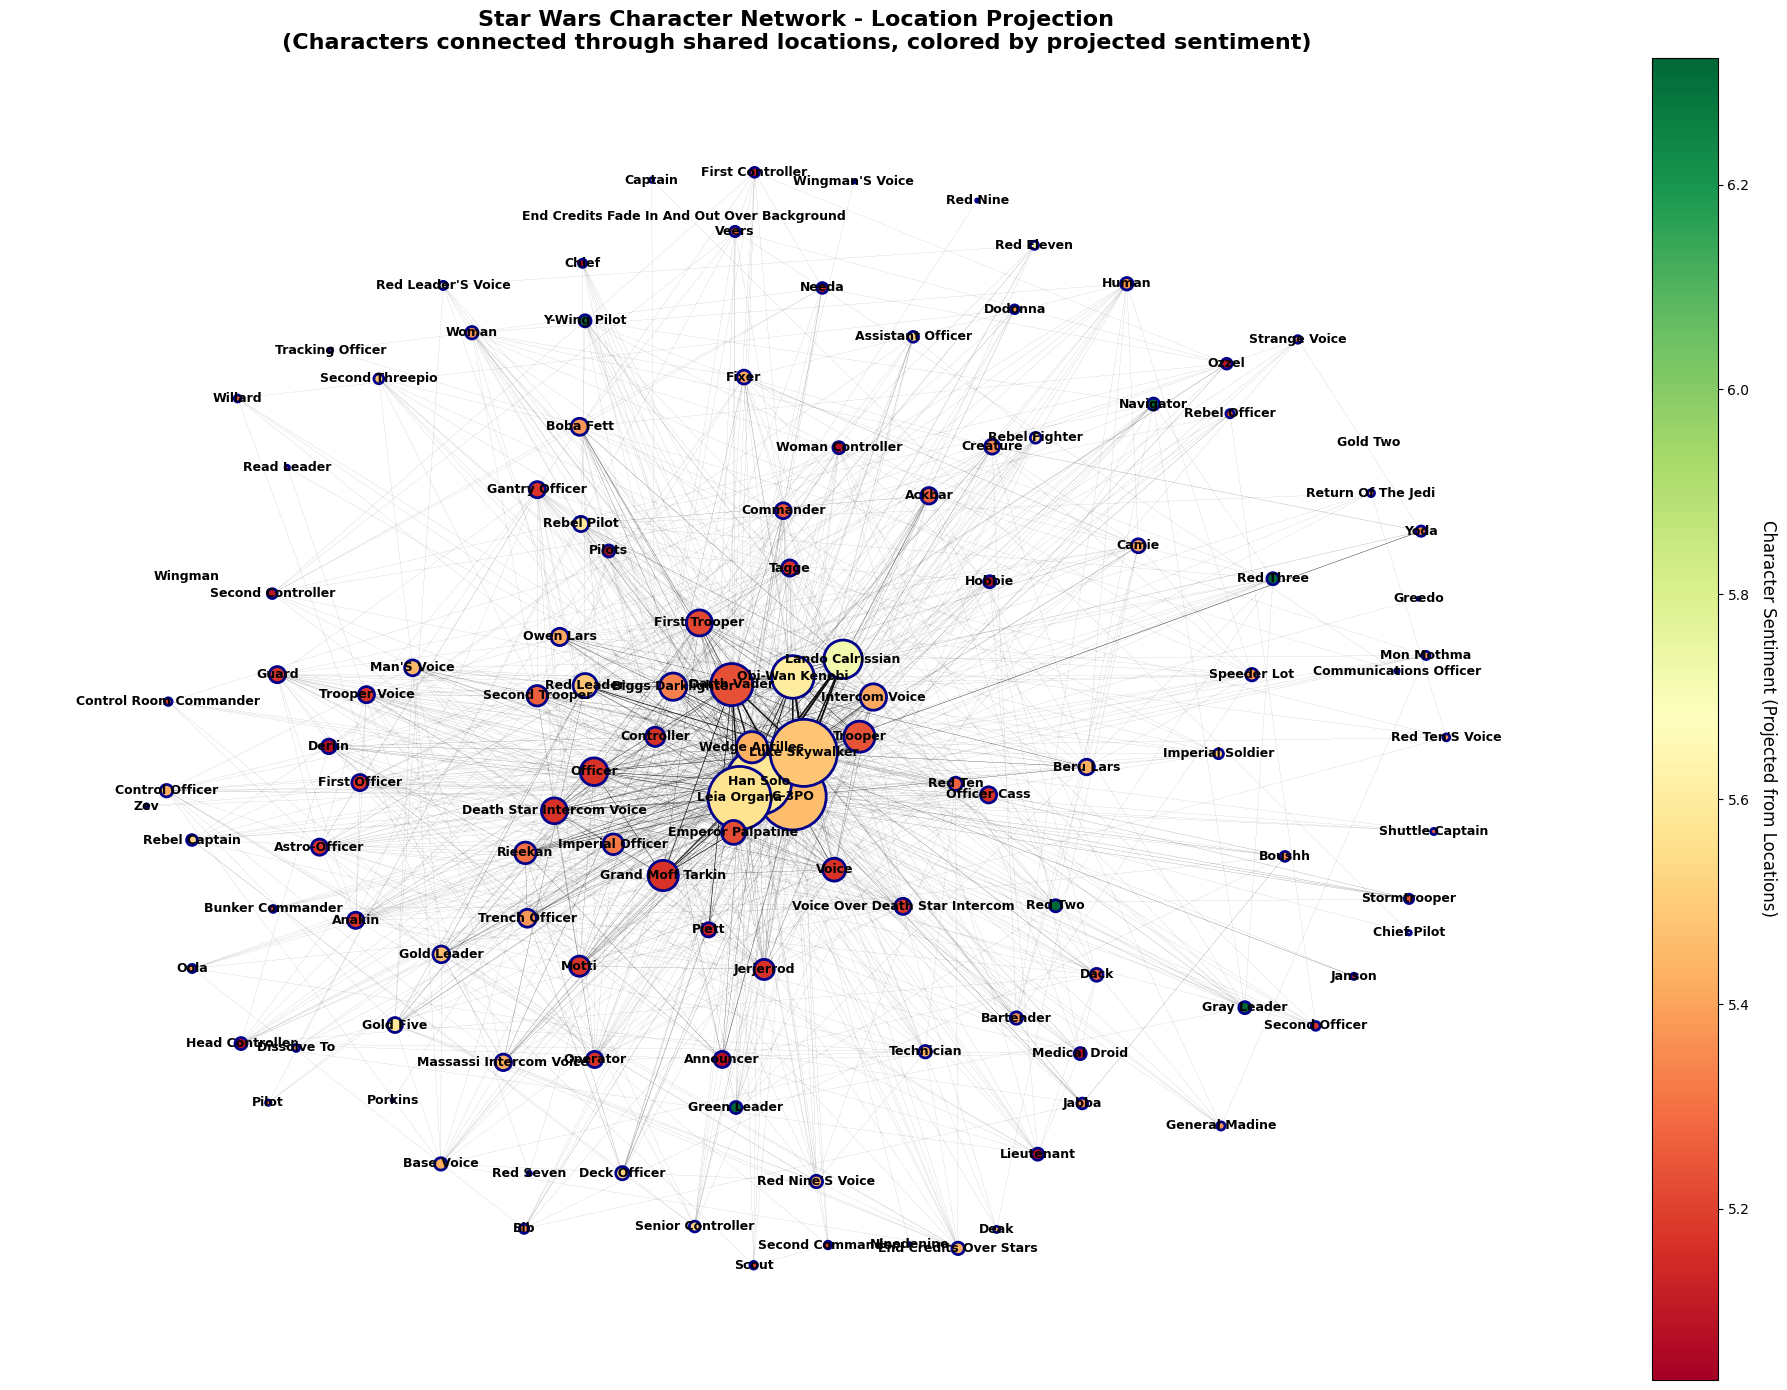


Projection Graph Statistics:
Number of characters: 128
Number of connections: 1141
Min sentiment: 5.033, Max sentiment: 6.324


In [ ]:
# get character sentiments based on connected locations sentiments
character_sentiments_subset = {}

for char in char_nodes:
    connected_locations = [n for n in G_bipartite.neighbors(char) if n in loc_nodes]
    
    if not connected_locations:
        character_sentiments_subset[char] = None
        continue
    
    weighted_sum = 0
    total_weight = 0
    
    for loc in connected_locations:
        weight = G_bipartite[char][loc]['weight']
        sentiment = G_bipartite.nodes[loc]['sentiment']
        
        if sentiment is not None:
            weighted_sum += sentiment * weight
            total_weight += weight
    
    if total_weight > 0:
        character_sentiments_subset[char] = weighted_sum / total_weight
    else:
        character_sentiments_subset[char] = None


# Create character-to-character projection graph
G_projection = nx.Graph()

# Add all character nodes with projected sentiments
for char in char_nodes:
    G_projection.add_node(char, sentiment=character_sentiments_subset[char])

# For each location, connect all pairs of characters that appear in it
for location in loc_nodes:
    # Get all characters connected to this location
    chars_in_location = [n for n in G_bipartite.neighbors(location) if n in char_nodes]
    
    # Connect all pairs of characters
    for i in range(len(chars_in_location)):
        for j in range(i + 1, len(chars_in_location)):
            char1 = chars_in_location[i]
            char2 = chars_in_location[j]
            
            # Get weights (how many times each character appears in this location)
            weight1 = G_bipartite[char1][location]['weight']
            weight2 = G_bipartite[char2][location]['weight']
            
            # Edge weight is the minimum of the two (conservative estimate of co-occurrence)
            edge_weight = min(weight1, weight2)
            
            # If edge already exists, add to its weight
            if G_projection.has_edge(char1, char2):
                G_projection[char1][char2]['weight'] += edge_weight
            else:
                G_projection.add_edge(char1, char2, weight=edge_weight)

# Get character sentiments for coloring
char_sentiments_proj = [G_projection.nodes[node]['sentiment'] if G_projection.nodes[node]['sentiment'] is not None else None for node in G_projection.nodes()]
char_sentiments_proj_clean = [s for s in char_sentiments_proj if s is not None]

min_sentiment_proj = min(char_sentiments_proj_clean) if char_sentiments_proj_clean else 1.0
max_sentiment_proj = max(char_sentiments_proj_clean) if char_sentiments_proj_clean else 10.0

char_sentiments_for_colors_proj = [G_projection.nodes[node]['sentiment'] if G_projection.nodes[node]['sentiment'] is not None else (min_sentiment_proj + max_sentiment_proj) / 2 for node in G_projection.nodes()]

# Create figure
fig, ax = plt.subplots(figsize=(18, 14))

# Use spring layout
pos_projection = nx.spring_layout(
    G_projection, k=1.5, iterations=50, seed=42, weight="weight"
)

# Node sizes based on degree
node_sizes = [G_projection.degree(node, weight='weight') * 5 for node in G_projection.nodes()]

# Draw character nodes with projected sentiment colors
nx.draw_networkx_nodes(
    G_projection,
    pos_projection,
    node_size=node_sizes,
    node_color=char_sentiments_for_colors_proj,
    cmap='RdYlGn',
    vmin=min_sentiment_proj,
    vmax=max_sentiment_proj,
    edgecolors="darkblue",
    linewidths=2,
    ax=ax,
)

# Draw edges
edges_proj = G_projection.edges()
weights_proj = [G_projection[u][v]["weight"] for u, v in edges_proj]
max_weight_proj = max(weights_proj) if weights_proj else 1
edge_widths_proj = [w / max_weight_proj * 4 for w in weights_proj]

nx.draw_networkx_edges(
    G_projection,
    pos_projection,
    width=edge_widths_proj,
    alpha=0.9,
    edge_color="black",
    ax=ax,
)

# Draw labels
nx.draw_networkx_labels(
    G_projection,
    pos_projection,
    font_size=9,
    font_weight="bold",
    ax=ax,
)

# Add colorbar for sentiment
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min_sentiment_proj, vmax=max_sentiment_proj))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Character Sentiment (Projected from Locations)', rotation=270, labelpad=20, fontsize=12)

ax.set_title(
    "Star Wars Character Network - Location Projection\n(Characters connected through shared locations, colored by projected sentiment)",
    fontsize=16,
    fontweight="bold",
)
ax.axis("off")
plt.tight_layout()
# save figure
plt.savefig('../figures/character_projection_network_with_sentiment.png', dpi=300)
plt.show()


Figure: Locations projected onto characters and sentiment of locations spreaded between them.

In [ ]:
print(f"\nProjection Graph Statistics:")
print(f"Number of characters: {G_projection.number_of_nodes()}")
print(f"Number of connections: {G_projection.number_of_edges()}")
print(f"Min sentiment: {min_sentiment_proj:.3f}, Max sentiment: {max_sentiment_proj:.3f}")

# mean of the projected character sentiments
valid_sentiments = [s for s in char_sentiments_proj if s is not None]
mean_sentiment = np.mean(valid_sentiments) if valid_sentiments else None
print(f"Mean projected character sentiment: {mean_sentiment:.3f}" if mean_sentiment is not None else "Mean projected character sentiment: N/A")

Mean projected character sentiment: 5.356
